In [1]:

#Sebastian Russo
#Artificial Intelligence

#Import necessary libraries
#Library to manipulate and analyze datasets 
import pandas as pd 
import numpy as np

#------------------------------------------------------------------------------------------------
#Import the Hierarchical clustering and other important related libraries
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
#For reducing dimensions to 2D for plotting
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from kneed import KneeLocator #For finding the best possible cluster

#Module contains various functions for evaluating the performance of the KMeans cluster
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist  #for distance metrics
#------------------------------------------------------------------------------------------------
#Library to make python matplotlib work like MATLAB
import matplotlib.pyplot as plt  
import matplotlib.cm as cm

#Library for data visualization
import seaborn as sns 

#To import the class in for feature scaling (standardize the range of independent variables)
from sklearn.preprocessing import StandardScaler #COMPLETELY OPTIONAL WE DECIDED TO USE

#To save the trained model
import os
import joblib

In [2]:
#Import data set
df_mall_customer_dataset = pd.read_csv("mall_customers.csv", encoding='ISO-8859-1')

#View shape of dataset (number of rows and columns)
print("Rows and Columns:", end="")
print(df_mall_customer_dataset.shape)

#Most and least common genders
print("Most common gender:", df_mall_customer_dataset['Gender'].mode()[0])
print("Least common gender:", df_mall_customer_dataset['Gender'].value_counts().idxmin())

#Analyze dataset by looking at first 5 rows
df_mall_customer_dataset.head(5)

Rows and Columns:(200, 5)
Most common gender: Female
Least common gender: Male


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
#Check if there is any missing values in the data (should always be done in large datasets)
num_missing_values=df_mall_customer_dataset.isna().sum() #or .isnull().sum()

#Print to see the missing values
print(num_missing_values)

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


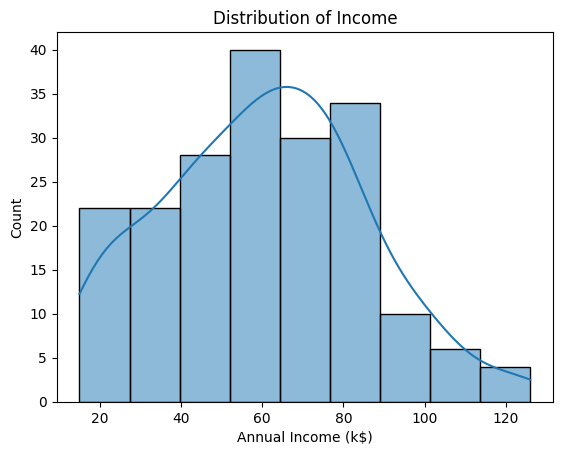

In [4]:
#Drop unnecessary column and encode Gender column
df_mall_customer_cleaned = df_mall_customer_dataset.drop('CustomerID', axis=1).copy()
df_mall_customer_cleaned['Gender'] = df_mall_customer_cleaned['Gender'].map({'Male': 0, 'Female': 1})


#Remove extreme outliers, 1%
df_mall_customer_cleaned = df_mall_customer_cleaned[
    (df_mall_customer_cleaned['Annual Income (k$)'] < 
    df_mall_customer_cleaned['Annual Income (k$)'].quantile(0.99)) &
    
    (df_mall_customer_cleaned['Spending Score (1-100)'] < 
    df_mall_customer_cleaned['Spending Score (1-100)'].quantile(0.99))
]

#Check data skewness and apply numpy solution
sns.histplot(df_mall_customer_cleaned['Annual Income (k$)'], kde=True)
plt.title('Distribution of Income')
#Save plot
os.makedirs('model_output', exist_ok=True)
plt.savefig('model_output/income_distribution_histogram.png', dpi=300, bbox_inches='tight')

plt.show()
df_mall_customer_cleaned['LogIncome'] = np.log1p(df_mall_customer_cleaned['Annual Income (k$)'])
df_mall_customer_cleaned['LogSpending'] = np.log1p(df_mall_customer_cleaned['Spending Score (1-100)'])

In [5]:
#Use log-transformed columns if available
features = df_mall_customer_cleaned[['Gender', 'Age', 'LogIncome', 'LogSpending']]

#Handle any inf or NaN values (precaution)
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)

#Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

C:\Users\Acer\AppData\Local\Temp\ipykernel_16920\3793999501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Acer\AppData\Local\Temp\ipykernel_16920\3793999501.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.dropna(inplace=True)


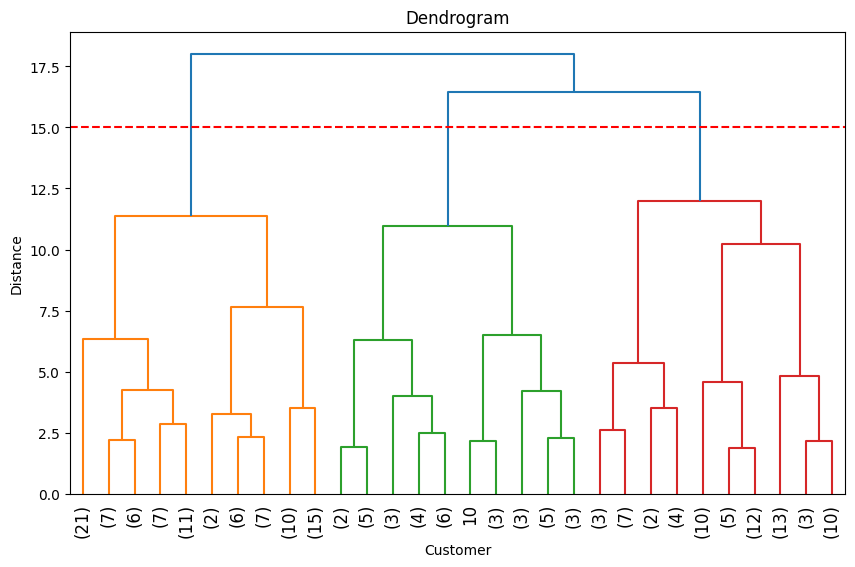

In [6]:
#Dendrogram Visual Inspection
Z = linkage(scaled_features, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=12)
plt.title("Dendrogram")
plt.xlabel("Customer")
plt.ylabel("Distance")
plt.axhline(y=15, color='r', linestyle='--')

#Save plot
plt.savefig('model_output/dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
#Implement Hierarchical clustering
optimal_k = 3
df_mall_customer_cleaned['Cluster'] = fcluster(Z, t=optimal_k, criterion='maxclust')

#Cluster profiling
cluster_profiles = df_mall_customer_cleaned.groupby('Cluster').agg({
    'Gender': lambda x: x.value_counts().idxmax(), #Most common gender
    'Age': 'mean',
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean',
}).rename(columns={'CustomerID': 'NumCustomers'})
print(df_mall_customer_cleaned['Cluster'].value_counts().sort_index())
print("Cluster Profiling Summary:")
print(cluster_profiles)

#Save the scaler
joblib.dump(scaler, 'model_output/hierarchical_scaler.pkl')
#Save the linkage matrix for future dendrogram plotting
np.save('model_output/hierarchical_linkage_matrix.npy', Z)
#Save clustered dataset
df_mall_customer_cleaned.to_csv('model_output/clustered_mall_customers.csv', index=False)

Cluster
1    92
2    35
3    69
Name: count, dtype: int64
Cluster Profiling Summary:
         Gender        Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                               
1             1  38.423913           66.945652               53.358696
2             1  36.400000           24.285714               43.000000
3             0  41.000000           69.376812               48.231884


In [8]:
#Compute metrics
sil_score = silhouette_score(scaled_features, df_mall_customer_cleaned['Cluster'])
calinski_harabasz = calinski_harabasz_score(scaled_features, df_mall_customer_cleaned['Cluster'])
davies_bouldin = davies_bouldin_score(scaled_features, df_mall_customer_cleaned['Cluster'])

print(f"Number of clusters: {optimal_k}")
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")


Number of clusters: 3
Silhouette Score: 0.300
Calinski-Harabasz Index: 59.17
Davies-Bouldin Index: 1.389


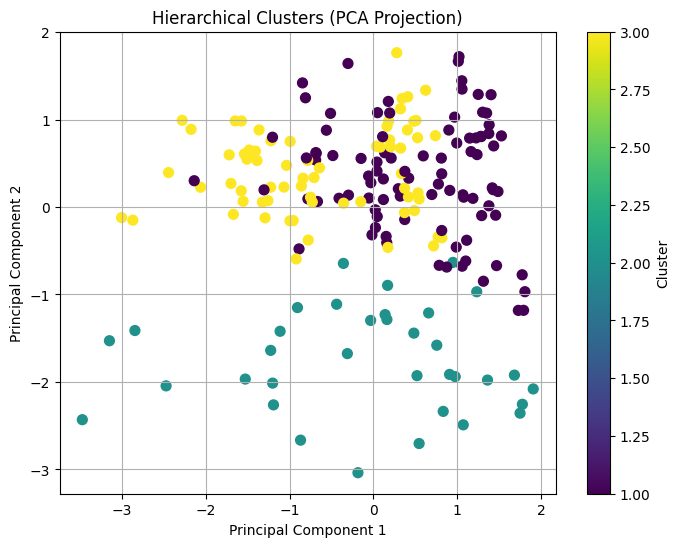

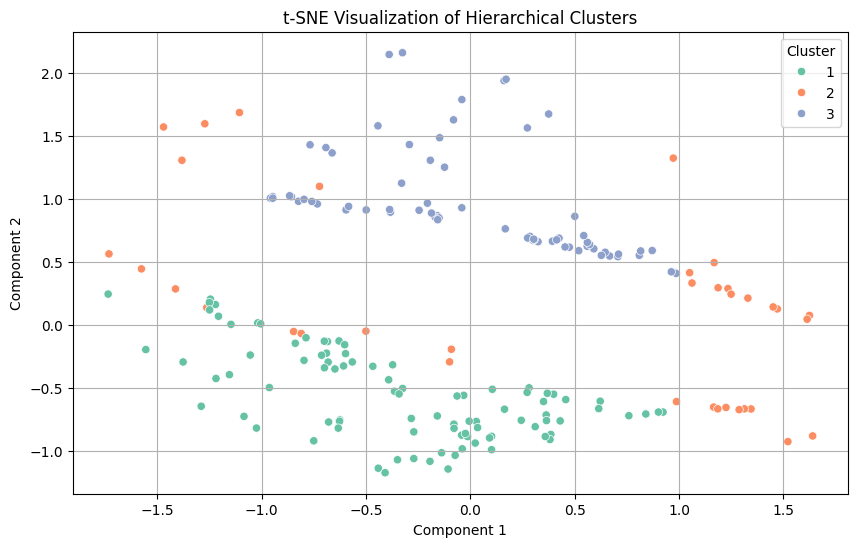

In [9]:
#PCA Visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], 
            c=df_mall_customer_cleaned['Cluster'], cmap='viridis', s=50)
plt.title("Hierarchical Clusters (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.grid(True)

plt.savefig('model_output/hierarchical_clusters_pca.png', dpi=300, bbox_inches='tight')
plt.show()


#t-SNE Visualization
tsne_results = TSNE(n_components=2, perplexity=150, random_state=42).fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], 
                hue=df_mall_customer_cleaned['Cluster'], palette='Set2')
plt.title("t-SNE Visualization of Hierarchical Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)

plt.savefig('model_output/hierarchical_clusters_tsne.png', dpi=300, bbox_inches='tight')
plt.show()


Silhouette Score for k=3: 0.300


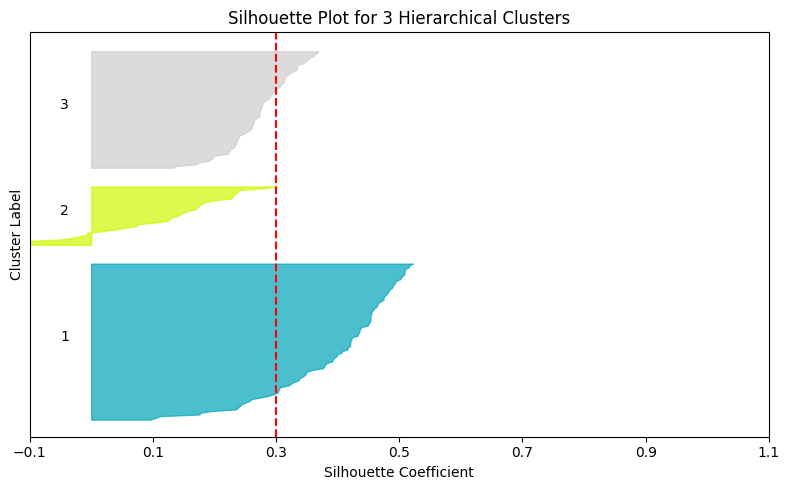

In [ ]:
#Number of clusters
optimal_k = len(np.unique(df_mall_customer_cleaned['Cluster']))

#Get cluster labels from hierarchical clustering
cluster_labels = df_mall_customer_cleaned['Cluster']

#Compute average silhouette score
silhouette_avg = silhouette_score(scaled_features, cluster_labels)
print(f"Silhouette Score for k={optimal_k}: {silhouette_avg:.3f}")

#Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(scaled_features, cluster_labels)

#Plot
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(8, 5)
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(scaled_features) + (optimal_k + 1) * 10])

y_lower = 10
for i in range(1, optimal_k + 1):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / optimal_k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_title(f"Silhouette Plot for {optimal_k} Hierarchical Clusters")
ax1.set_xlabel("Silhouette Coefficient")
ax1.set_ylabel("Cluster Label")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])
ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

plt.tight_layout()
plt.savefig('model_output/silhouette_plot.png', dpi=300, bbox_inches='tight')
plt.show()